# Installs & Imports

In [38]:
!pip install -q shap

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import shap
import random
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from copy import deepcopy
import os
import sys
import itertools
import joblib
import logging
import warnings

In [ ]:
def configure_logging(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout
):
    """Configures the root logger with a StreamHandler.

    Args:
        level (int): Logging level for both logger and handler (default: logging.INFO).
        format (str): Format string for log messages (default: '%(asctime)s - %(levelname)s - %(message)s').
        stream: Output stream for the handler (default: sys.stdout).
    """
    logger = logging.getLogger()

    # Clear existing handlers to avoid duplication
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create and configure handler
    stream_handler = logging.StreamHandler(stream)
    stream_handler.setLevel(level)

    # Create formatter and add to handler
    formatter = logging.Formatter(format)
    stream_handler.setFormatter(formatter)

    # Add handler to logger and set logging level
    logger.addHandler(stream_handler)
    logger.setLevel(level)

    # Test logging configuration
    logging.info("Logging is configured.")

# Configure logging to print in notebook
configure_logging()

2025-01-25 20:40:43,970 - INFO - Logging is configured.


In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
# Set seed
set_seed(42)

# Data Loading

In [ ]:
def generate_synthetic_stock_data(num_days=1500, start_price=100,
                                  trend=0.05, seasonality_amplitude=5, noise_std=2):
    """
    Generates synthetic stock data using a random walk with trend and seasonality.

    Parameters:
    - num_days: Number of days to generate data for.
    - start_price: Starting price of the stock.
    - trend: Daily trend component.
    - seasonality_amplitude: Amplitude of the seasonal component.
    - noise_std: Standard deviation of the Gaussian noise.

    Returns:
    - DataFrame with 'date' and 'price' columns.
    """
    dates = [datetime.today() - timedelta(days=i) for i in range(num_days)]
    dates = sorted(dates)

    # Generate trend
    trend_component = np.linspace(0, trend * num_days, num_days)

    # Generate seasonality (yearly seasonality with weekly patterns)
    seasonal_component = seasonality_amplitude * np.sin(2 * np.pi * np.arange(num_days) / 365)

    # Generate random walk
    random_walk = np.random.normal(loc=0, scale=noise_std, size=num_days).cumsum()

    # Combine all components
    price = start_price + trend_component + seasonal_component + random_walk

    df = pd.DataFrame({
        'date': dates,
        'price': price
    })

    return df

In [ ]:
# Generate synthetic data
df_stock = generate_synthetic_stock_data(
    num_days=1500,
    start_price=100,
    trend=0.05,
    seasonality_amplitude=5,
    noise_std=2
)

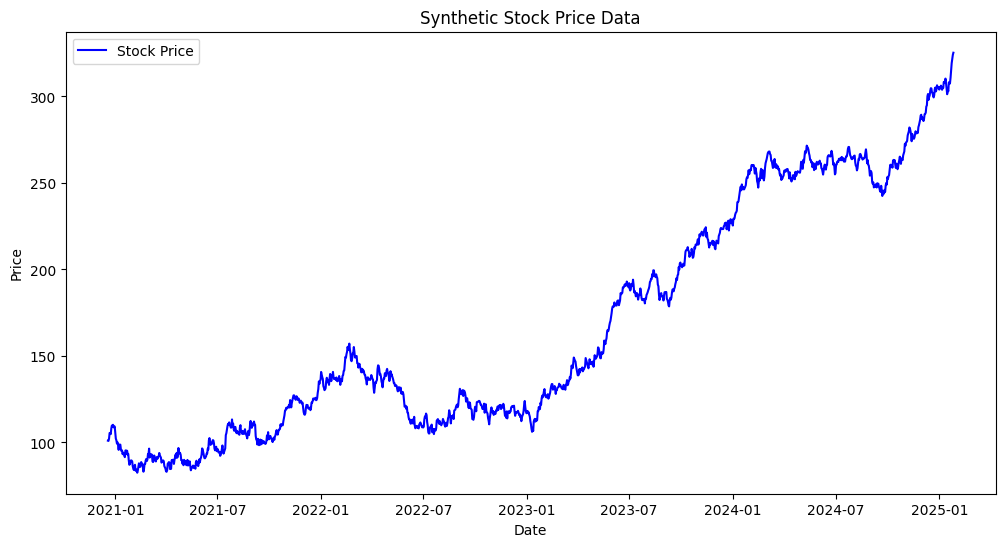

In [ ]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_stock['date'], df_stock['price'], label='Stock Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Synthetic Stock Price Data')
plt.legend()
plt.show()

# Data Preprocessing

In [ ]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds time-based and cyclical features to the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'date' column.

    Returns:
    - pd.DataFrame: DataFrame with additional time-based and cyclical features.
    """
    df = df.copy()
    df['day_of_week'] = 1 + df['date'].dt.day_of_week
    df['month'] = df['date'].dt.month

    # Cyclical encoding for day of week
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

In [ ]:
def feature_engineering(df: pd.DataFrame, target_column: str = 'price') -> pd.DataFrame:
    """
    Performs feature engineering by adding statistical features.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the stock data.
    - target_column (str): Column name of the target variable.

    Returns:
    - pd.DataFrame: DataFrame with additional statistical features.
    """
    df = df.copy()

    # Price change
    df['price_change'] = df[target_column].diff()

    # Moving averages
    df['moving_avg_5'] = df[target_column].rolling(window=5).mean()
    df['moving_avg_10'] = df[target_column].rolling(window=10).mean()

    # Rolling standard deviations
    df['rolling_std_5'] = df[target_column].rolling(window=5).std()
    df['rolling_std_10'] = df[target_column].rolling(window=10).std()

    return df

In [ ]:
def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15
) -> tuple:
    """
    Splits the data into training, validation, and test sets while preserving temporal order.

    Parameters:
    - X (pd.DataFrame): Features.
    - y (pd.Series): Targets.
    - train_ratio (float): Proportion of data to use for training.
    - val_ratio (float): Proportion of data to use for validation.

    Returns:
    - tuple: X_train, X_val, X_test, y_train, y_val, y_test
    """
    total_samples = len(X)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    X_train = X.iloc[:train_end]
    X_val = X.iloc[train_end:val_end]
    X_test = X.iloc[val_end:]

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def create_sequences(X: np.ndarray, y: np.ndarray, sequence_length: int = 20) -> tuple:
    """
    Creates input sequences and corresponding targets for LSTM.

    Parameters:
    - X (np.ndarray): Array of features.
    - y (np.ndarray): Array of targets.
    - sequence_length (int): Number of time steps in each sequence.

    Returns:
    - tuple: X_sequences, y_sequences
    """
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

In [ ]:
def preprocess_data(
    df: pd.DataFrame,
    target_column: str = 'price',
    sequence_length: int = 20,
    scale: bool = True
) -> tuple:
    """
    Preprocesses the stock data for LSTM modeling by adding features, scaling, and creating sequences.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the stock data with 'date' and 'price' columns.
    - target_column (str): Column name of the target variable.
    - sequence_length (int): Number of time steps in each sequence.
    - scale (bool): Whether to scale the features.

    Returns:
    - tuple: X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler, feature_columns
    """
    df = df.copy()

    # Add time-based and cyclical features
    df = add_time_features(df)
    print(f"Data shape after adding time features: {df.shape}")

    # Feature engineering
    df = feature_engineering(df, target_column=target_column)
    print(f"\nData shape after feature engineering: {df.shape}")

    # Drop NaN values resulting from rolling calculations
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"\nData shape after dropping NA: {df.shape}")

    # Define features and target
    feature_columns = [
        'price',
        'price_change',
        'moving_avg_5',
        'moving_avg_10',
        'rolling_std_5',
        'rolling_std_10',
        'day_of_week',
        'month',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos'
    ]

    X = df[feature_columns]
    y = df['price']
    print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")

    # Split data before scaling to prevent leakage
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(
        X, y, train_ratio=0.7, val_ratio=0.15
    )
    print("\nAfter splitting:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Scaling
    scaler = None
    if scale:
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=feature_columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_columns)
        print("\nAfter scaling:")
        print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_val.values, y_val.values, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, sequence_length)
    print("\nAfter creating sequences:")
    print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
    print(f"X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
    print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

    return (
        X_train_seq, y_train_seq,
        X_val_seq, y_val_seq,
        X_test_seq, y_test_seq,
        scaler, feature_columns
    )

In [ ]:
# Preprocess the data
sequence_length = 20
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler, feature_names = preprocess_data(
    df_stock,
    target_column='price',
    sequence_length=sequence_length,
    scale=True
)

Data shape after adding time features: (1500, 8)

Data shape after feature engineering: (1500, 13)

Data shape after dropping NA: (1491, 13)
Features (X) shape: (1491, 12), Target (y) shape: (1491,)

After splitting:
X_train: (1043, 12), y_train: (1043,)
X_val: (223, 12), y_val: (223,)
X_test: (225, 12), y_test: (225,)

After scaling:
X_train: (1043, 12), X_val: (223, 12), X_test: (225, 12)

After creating sequences:
X_train_seq: (1023, 20, 12), y_train_seq: (1023,)
X_val_seq: (203, 20, 12), y_val_seq: (203,)
X_test_seq: (205, 20, 12), y_test_seq: (205,)


In [ ]:
def create_dataloader(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 64,
    shuffle: bool = False
) -> DataLoader:
    """
    Creates a DataLoader for the given data.

    Parameters:
    - X (np.ndarray): Input sequences.
    - y (np.ndarray): Targets.
    - batch_size (int): Number of samples per batch.
    - shuffle (bool): Whether to shuffle the data.

    Returns:
    - DataLoader: PyTorch DataLoader.
    """
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
# Create DataLoaders for each split
batch_size = 64
train_loader = create_dataloader(X_train_seq, y_train_seq, batch_size=batch_size, shuffle=True)
val_loader = create_dataloader(X_val_seq, y_val_seq, batch_size=batch_size, shuffle=False)
test_loader = create_dataloader(X_test_seq, y_test_seq, batch_size=batch_size, shuffle=False)

In [ ]:
# Check the train_loader
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

X_batch shape: torch.Size([64, 20, 12])
y_batch shape: torch.Size([64])


# Model Definition

In [ ]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        output_size: int = 1,
        dropout: float = 0.1
    ) -> None:
        """
        Initializes the LSTM model for regression tasks.

        Parameters:
        - input_size (int): Number of input features per time step.
        - hidden_size (int): Number of features in the hidden state.
        - num_layers (int): Number of stacked LSTM layers.
        - output_size (int): Number of output neurons. Default is 1 for regression.
        - dropout (float): Dropout probability for LSTM layers. Default is 0.1.

        Example:
        >>> model = LSTMModel(input_size=10, hidden_size=64, num_layers=2)
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer with dropout
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Define the output layer
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Initialize weights for the output layer
        nn.init.xavier_uniform_(self.output_linear.weight)
        nn.init.constant_(self.output_linear.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the LSTM model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, output_size)
        """
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size
        ).to(x.device)

        c0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size
        ).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.output_linear(out[:, -1, :])  # (batch_size, output_size)

        return out  # Output shape: (batch_size, 1)

In [ ]:
# Define model parameters
input_size = X_train_seq.shape[2]  # Number of features
hidden_size = 512
num_layers = 3
output_size = 1
dropout = 0.1

# Instantiate the model
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

In [ ]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=10,
    threshold=0.0001,
)

# Model Training

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    feature_names: list,
    num_epochs: int = 100,
    patience: int = 10,
    log_weights: bool = True,
    weight_logging_interval: int = 5,
    gradient_clipping: float = 1.0
) -> tuple:
    """
    Trains the LSTM model with early stopping and logs feature weights.

    Parameters:
    - model (nn.Module): The LSTM model.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
    - device (torch.device): Device to run the model on.
    - feature_names (list): List of feature names.
    - num_epochs (int): Maximum number of epochs. Default is 100.
    - patience (int): Number of epochs to wait for improvement before stopping. Default is 10.
    - log_weights (bool): If True, log feature weights every `weight_logging_interval` epochs. Default is True.
    - weight_logging_interval (int): Interval (in epochs) at which to log feature weights. Default is 5.
    - gradient_clipping (float): Maximum norm for gradient clipping. Default is 1.0.

    Returns:
    - model (nn.Module): Trained model with the best validation loss.
    - history (dict): Dictionary containing training and validation loss and metrics.
    - feature_weights_log (dict): Dictionary logging feature weights across epochs.
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'val_r2': []
    }

    feature_weights_log = {feature: [] for feature in feature_names} if log_weights else {}

    best_val_rmse = float('inf')
    trigger_times = 0
    best_epoch = 0

    # Check if DataLoaders are not empty
    if len(train_loader) == 0:
        raise ValueError("Train DataLoader is empty.")
    if len(val_loader) == 0:
        raise ValueError("Validation DataLoader is empty.")

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping)

            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # Calculate training loss immediately after training
        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        preds = []
        targets = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                preds.extend(outputs.cpu().numpy())
                targets.extend(y_batch.cpu().numpy())

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_rmse = np.sqrt(mean_squared_error(targets, preds))
        val_mae = mean_absolute_error(targets, preds)
        val_r2 = r2_score(targets, preds)

        # Update learning rate scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)  # For plateau-based scheduling
        else:
            scheduler.step()  # For other schedulers (e.g., StepLR)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        history['val_r2'].append(val_r2)

        # Logging
        current_lr = optimizer.param_groups[0]['lr']
        logging.info(
            f"Epoch [{epoch}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val RMSE: {val_rmse:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # Feature weight logging
        if log_weights and (epoch % weight_logging_interval == 0):
            with torch.no_grad():
                lstm_weight_ih = None
                for name, param in model.named_parameters():
                    if 'weight_ih_l0' in name:  # First LSTM layer input weights
                        lstm_weight_ih = param.cpu().numpy()
                        break
                if lstm_weight_ih is not None:
                    avg_weights = lstm_weight_ih.mean(axis=0)
                    for i, feature in enumerate(feature_names):
                        if i < len(avg_weights):
                            feature_weights_log[feature].append(avg_weights[i])

        # Early stopping check
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            trigger_times = 0
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                logging.info(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model weights
    if os.path.exists('best_model.pth'):
        model.load_state_dict(torch.load('best_model.pth', weights_only=True))
        logging.info(f"Loaded best model from epoch {best_epoch} | Val RMSE: {best_val_rmse:.4f}")

    return model, history, feature_weights_log

In [ ]:
# Define training parameters
num_epochs = 500
patience = 50
gradient_clipping = 1.0

# Train the model
model, history, feature_weights_log = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    feature_names=feature_names,
    num_epochs=num_epochs,
    patience=patience,
    log_weights=True,
    weight_logging_interval=5,
    gradient_clipping=gradient_clipping
)

2025-01-25 20:40:51,007 - INFO - Epoch [1/500] | Train Loss: 10604.7798 | Val Loss: 37404.2956 | Val RMSE: 193.4019 | LR: 0.010000
2025-01-25 20:40:51,309 - INFO - Epoch [2/500] | Train Loss: 3881.9693 | Val Loss: 22303.3828 | Val RMSE: 149.3432 | LR: 0.010000
2025-01-25 20:40:51,623 - INFO - Epoch [3/500] | Train Loss: 1264.9795 | Val Loss: 12487.8000 | Val RMSE: 111.7488 | LR: 0.010000
2025-01-25 20:40:51,926 - INFO - Epoch [4/500] | Train Loss: 1132.3621 | Val Loss: 15294.7615 | Val RMSE: 123.6720 | LR: 0.010000
2025-01-25 20:40:52,185 - INFO - Epoch [5/500] | Train Loss: 1087.1279 | Val Loss: 13591.9960 | Val RMSE: 116.5847 | LR: 0.010000
2025-01-25 20:40:52,443 - INFO - Epoch [6/500] | Train Loss: 1088.2121 | Val Loss: 16033.3546 | Val RMSE: 126.6229 | LR: 0.010000
2025-01-25 20:40:52,727 - INFO - Epoch [7/500] | Train Loss: 1088.4279 | Val Loss: 14224.1943 | Val RMSE: 119.2652 | LR: 0.010000
2025-01-25 20:40:52,982 - INFO - Epoch [8/500] | Train Loss: 1077.1875 | Val Loss: 14589.

# Metrics Evaluation

In [ ]:
def evaluate_model_regression(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> dict:
    """
    Evaluates the model on the given data loader for regression tasks.

    Parameters:
    - model (nn.Module): Trained LSTM model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
    - criterion (nn.Module): Loss function (e.g., nn.MSELoss()).
    - device (torch.device): Device to run the evaluation on (CPU or GPU).

    Returns:
    - metrics (dict): Dictionary containing:
        - 'avg_loss' (float): Average loss over the dataset.
        - 'rmse' (float): Root Mean Squared Error.
        - 'mae' (float): Mean Absolute Error.
        - 'r2' (float): R² Score.
        - 'preds' (list): List of model predictions.
        - 'targets' (list): List of true target values.
    """
    if len(data_loader) == 0:
        raise ValueError("DataLoader is empty.")

    model.eval()
    total_loss = 0.0
    preds = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch).squeeze()
            batch_loss = criterion(outputs, y_batch)
            total_loss += batch_loss.item() * X_batch.size(0)

            preds.extend(outputs.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)

    metrics = {
        'avg_loss': avg_loss,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'preds': preds,
        'targets': targets
    }

    # Log the evaluation metrics
    logging.info(f"Evaluation Metrics - Loss: {avg_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return metrics

In [ ]:
# Evaluate on validation set
try:
    val_metrics = evaluate_model_regression(
        model=model,
        data_loader=val_loader,
        criterion=criterion,
        device=device
    )
except Exception as e:
    logging.error(f"An error occurred during validation evaluation: {e}")
    raise

2025-01-25 20:41:04,646 - INFO - Evaluation Metrics - Loss: 12487.8000, RMSE: 111.7488, MAE: 110.7080, R²: -52.9364


In [ ]:
# Create a DataFrame for validation metrics
val_metrics_df = pd.DataFrame({
    'Metric': ['Loss', 'RMSE', 'MAE', 'R²'],
    'Value': [val_metrics['avg_loss'], val_metrics['rmse'], val_metrics['mae'], val_metrics['r2']]
})

# Display the validation metrics
display(val_metrics_df)

,Metric,Value
0,Loss,12487.799963
1,RMSE,111.748827
2,MAE,110.708048
3,R²,-52.936366


In [ ]:
# Evaluate on test set
try:
    test_metrics = evaluate_model_regression(
        model=model,
        data_loader=test_loader,
        criterion=criterion,
        device=device
    )
except Exception as e:
    logging.error(f"An error occurred during test evaluation: {e}")
    raise

2025-01-25 20:41:04,699 - INFO - Evaluation Metrics - Loss: 18668.8342, RMSE: 136.6339, MAE: 135.0865, R²: -43.3998


In [ ]:
# Create a DataFrame for test metrics
test_metrics_df = pd.DataFrame({
    'Metric': ['Loss', 'RMSE', 'MAE', 'R²'],
    'Value': [test_metrics['avg_loss'], test_metrics['rmse'], test_metrics['mae'], test_metrics['r2']]
})

# Display the test metrics
display(test_metrics_df)

,Metric,Value
0,Loss,18668.834156
1,RMSE,136.633943
2,MAE,135.086505
3,R²,-43.399841


# SHAP Importances

In [ ]:
# Make copy of the model
model_copy = deepcopy(model)

# Define the model used for SHAP analysis
model_shap = model_copy.to('cpu').eval()

In [ ]:
# Define data for SHAP
X_background = X_train_seq[:100]
X_explain = X_test_seq[:200]

# Convert to PyTorch tensors
X_background_torch = torch.tensor(X_background, dtype=torch.float32).to('cpu')
X_explain_torch = torch.tensor(X_explain, dtype=torch.float32).to('cpu')

# Print shapes to confirm
print("X_background shape:", X_background_torch.shape)
print("X_explain shape:", X_explain_torch.shape)

X_background shape: torch.Size([100, 20, 12])
X_explain shape: torch.Size([200, 20, 12])


In [ ]:
# Feature names
feature_names = [
    'price',
    'price_change',
    'moving_avg_5',
    'moving_avg_10',
    'rolling_std_5',
    'rolling_std_10',
    'day_of_week',
    'month',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos'
]

In [ ]:
# Initialize SHAP DeepExplainer with the model and background data
explainer = shap.DeepExplainer(model_shap, [X_background_torch])

In [ ]:
warnings.filterwarnings("ignore", message="unrecognized nn.Module: LSTM")

# Select a subset for explanation
num_samples = 100
X_explain_subset_torch = X_explain_torch[:num_samples]

# Generate SHAP values
shap_values = explainer.shap_values([X_explain_subset_torch])
shap_values = shap_values[0]
shap_values.shape

(100, 20, 12, 1)

In [ ]:
# Aggregate SHAP values across samples and sequence steps (flatten to 1D)
shap_values_aggregated = np.mean(np.abs(shap_values), axis=(0, 1)).squeeze()

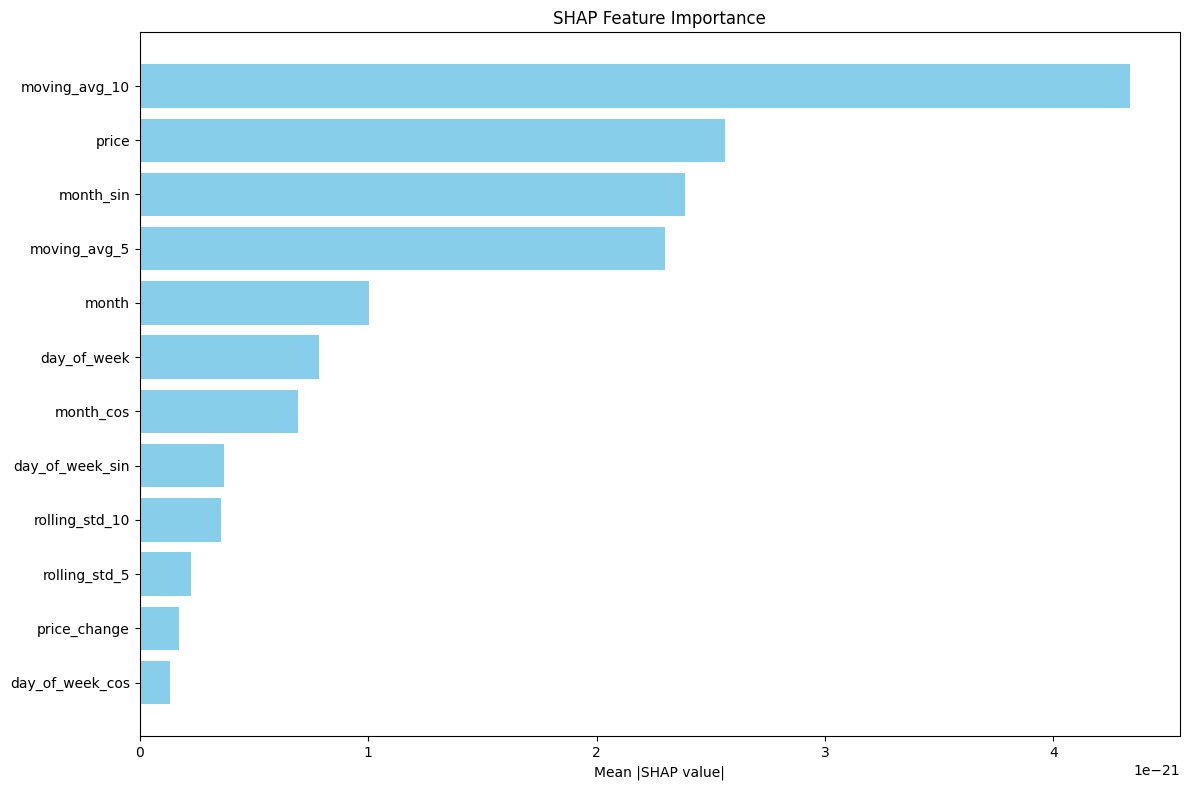

In [ ]:
# Plot aggregated feature importances
plt.figure(figsize=(12, 8))
sorted_indices = np.argsort(shap_values_aggregated)

plt.barh(
    np.array(feature_names)[sorted_indices],
    shap_values_aggregated[sorted_indices],
    color='skyblue'
)

plt.xlabel('Mean |SHAP value|')
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

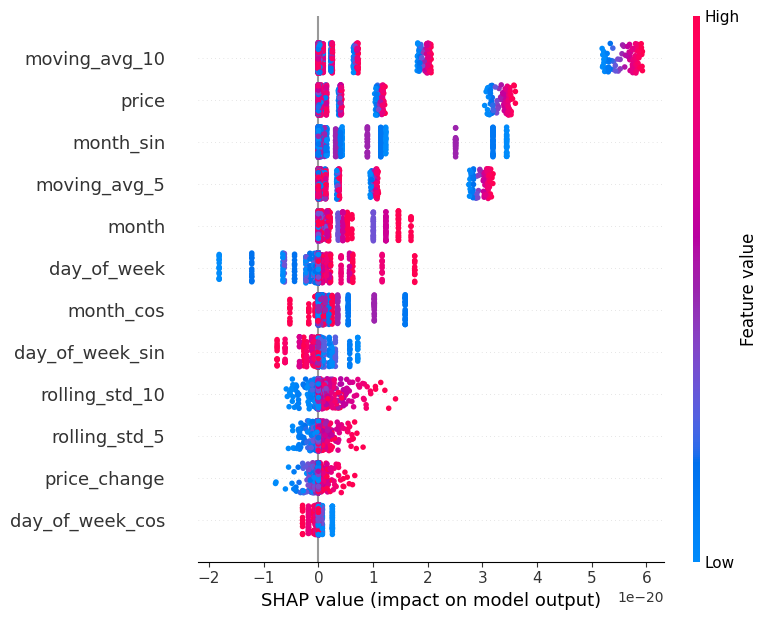

In [ ]:
# Reshape features and shap_values for summary plot
sequence_length = X_explain_subset_torch.shape[1]
num_features = X_explain_subset_torch.shape[2]

# Flatten the data: (num_samples, seq_length, num_features) -> (num_samples * seq_length, num_features)
features_reshaped = X_explain_subset_torch.reshape(-1, num_features).numpy()

# Flatten SHAP values similarly
shap_values_flat = shap_values.reshape(-1, num_features)

# Create SHAP summary plot
shap.summary_plot(
    shap_values_flat,
    features=features_reshaped,
    feature_names=feature_names,
    show=True
)

# Weight Importances

In [ ]:
def track_feature_weights_across_epochs(feature_weights_log: dict, feature_names: list, interval: int = 5):
    """
    Plots feature weights across training epochs.

    Parameters:
    - feature_weights_log (dict): Dictionary logging feature weights across epochs.
    - feature_names (list): List of feature names.
    - interval (int): Interval at which weights were logged (in epochs).

    Returns:
    - None
    """
    plt.figure(figsize=(12, 8))
    for feature in feature_names:
        weights = feature_weights_log.get(feature, [])
        epochs = list(range(interval, interval * len(weights) + 1, interval))
        plt.plot(epochs, weights, label=feature)
    plt.xlabel('Epoch')
    plt.ylabel('Average Input Weight')
    plt.title('Feature Weights Across Training Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

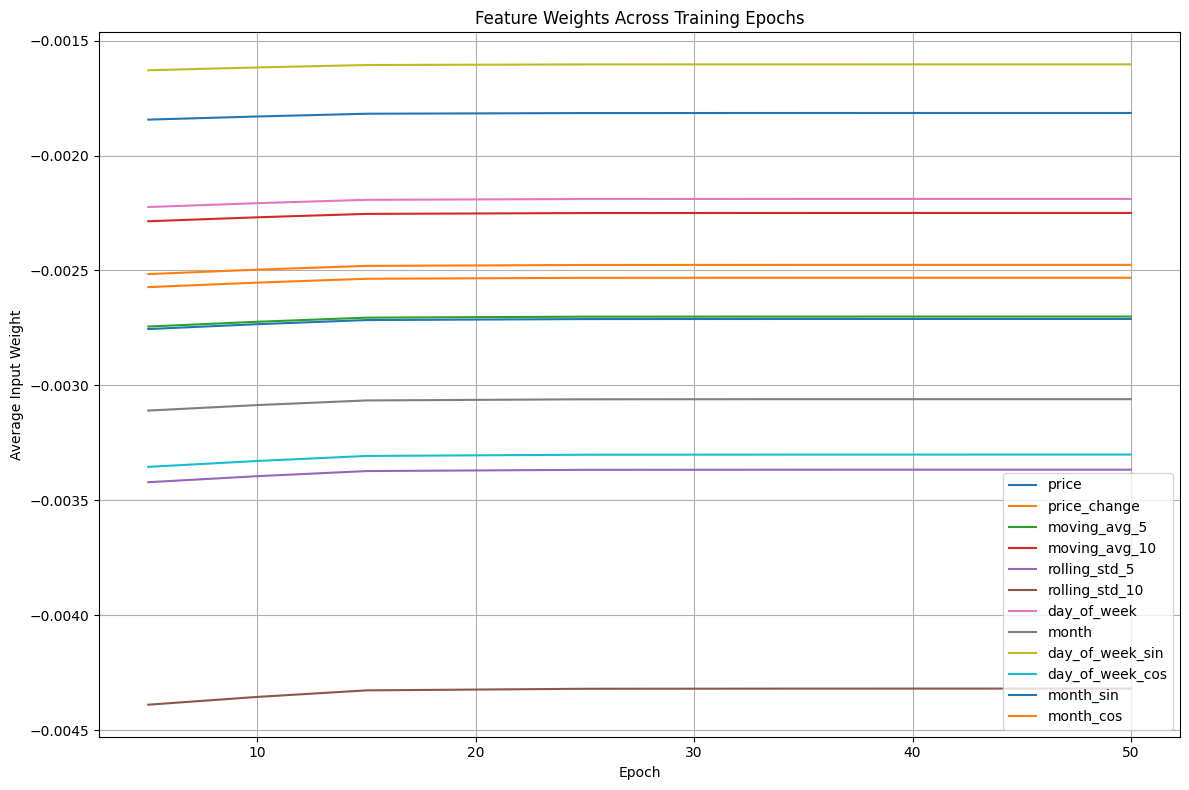

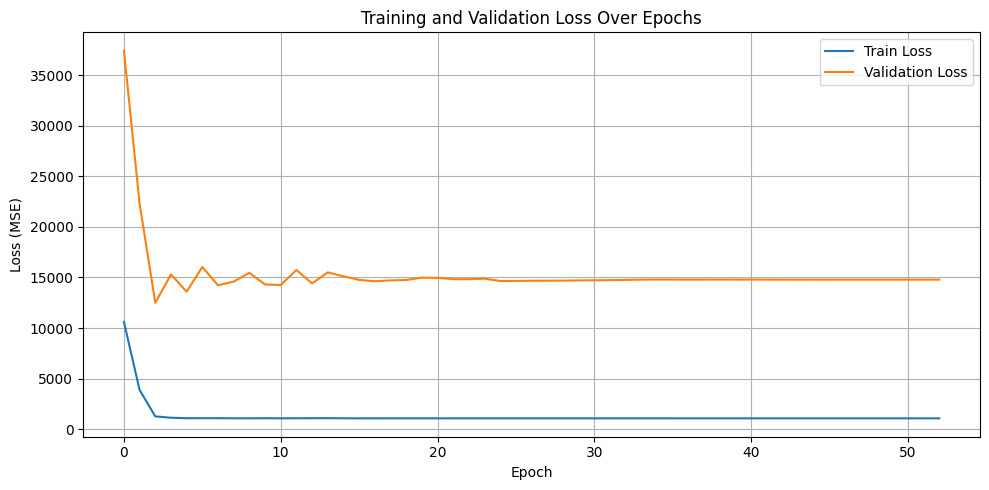

In [ ]:
# Plot feature weights
track_feature_weights_across_epochs(feature_weights_log, feature_names, interval=5)
print("\n")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()